In [9]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import TruncatedSVD

In [10]:
df = pd.read_csv('MLNS_05292024.csv')

/var/folders/5z/7fkzpcz93gz6mqgh9vjgfymm0000gn/T/ipykernel_19624/259242732.py:1: DtypeWarning: Columns (25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MLNS_05292024.csv')


In [11]:
#Returns dataframe containing mfcc avg and var, and hs_mfcc avg and var, truncated to indicated depth, as well as Calvin's three features if True
def truncate_mfcc(df, avg_depth=20, var_depth=10, hs_avg_depth=20, hs_var_depth=10, calvin_Features=True, peak=True):
    df_temp=df['mfcc_'+str(0)+'_avg']
    df_temp=df_temp.rename('blah')
    for n in range(0,avg_depth):
        df_temp=pd.concat([df_temp, df['mfcc_'+str(n)+'_avg']], axis=1)
    for n in range(0,var_depth):
        df_temp=pd.concat([df_temp, df['mfcc_'+str(n)+'_var']], axis=1)
    for n in range(0,hs_avg_depth):
        df_temp=pd.concat([df_temp, df['hs_mfcc_'+str(n)+'_avg']], axis=1)
    for n in range(0,hs_var_depth):
        df_temp=pd.concat([df_temp, df['hs_mfcc_'+str(n)+'_var']], axis=1)
    if calvin_Features:
        df_temp=pd.concat([df_temp, df['main_freq']], axis=1)
        df_temp=pd.concat([df_temp, df['range']], axis=1)
        df_temp=pd.concat([df_temp, df['max_mean']], axis=1)
    if peak:
        df_temp=pd.concat([df_temp, df['peak_freq']], axis=1)
    return df_temp.drop(columns=['blah'])

In [61]:
empty_fam_df

0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

In [72]:
pd.DataFrame(0, index=np.arange(4), columns=['Gryllinae', 'Conocephalinae', 'Oecanthinae',
            'Phaneropterinae', 'Trigonidiinae', 'Nemobiinae', 'Hapithinae', 
            'Mogoplistinae', 'Tettigoniinae', 'Pseudophyllinae', 'Cicadidae',
            'Gryllotalpidae', 'Eneopterinae', 'Phalangopsidae', 'Listroscelidinae'])

,Gryllinae,Conocephalinae,Oecanthinae,Phaneropterinae,Trigonidiinae,Nemobiinae,Hapithinae,Mogoplistinae,Tettigoniinae,Pseudophyllinae,Cicadidae,Gryllotalpidae,Eneopterinae,Phalangopsidae,Listroscelidinae
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
def fam_to_num(ser):
    temp = pd.DataFrame(0, index=np.arange(len(ser)), columns=['Gryllinae', 'Conocephalinae', 'Oecanthinae',
            'Phaneropterinae', 'Trigonidiinae', 'Nemobiinae', 'Hapithinae', 
            'Mogoplistinae', 'Tettigoniinae', 'Pseudophyllinae', 'Cicadidae',
            'Gryllotalpidae', 'Eneopterinae', 'Phalangopsidae', 'Listroscelidinae'])
    for i in range(0,len(ser)):
        temp.at[i,ser[i]] = 1
    return temp   

In [16]:
fam_dict = {'Gryllinae':'cricket', 'Conocephalinae':'kaydid', 'Oecanthinae':'cricket',
            'Phaneropterinae': 'kaydid', 'Trigonidiinae':'cricket', 'Nemobiinae':'cricket', 'Hapithinae':'cricket', 
            'Mogoplistinae':'cricket', 'Tettigoniinae':'kaydid', 'Pseudophyllinae':'kaydid', 'Cicadidae':'cicada',
            'Gryllotalpidae':'cricket', 'Eneopterinae':'cricket', 'Phalangopsidae':'cricket', 'Listroscelidinae':'cricket'}

#Computes the accuracy of knn at the given value of k, depths of mfcc features, Calvin's features, and critter vs. fam_or_subfam
def knn_test_acc(df, k=5, avg_depth=20, var_depth=10, hs_avg_depth=20, hs_var_depth=10, calvin_Features=True, peak=True, crit=False):
    X=truncate_mfcc(df=df, avg_depth=avg_depth,var_depth=var_depth,hs_avg_depth=hs_avg_depth,hs_var_depth=hs_var_depth,calvin_Features=calvin_Features, peak=peak)
    if crit:
        Y = df['critter_name']
    else:
        Y = df['fam_or_subfam']
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), Y, shuffle=True, random_state=17, test_size=.2, stratify=Y)
    knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(k))])
    knn_pipe.fit(X_train, y_train)
    pred = knn_pipe.predict(X_test)
    score = accuracy_score(y_test,pred)
    print(y_test)
    return score

#Computes the accuracy of SVM poly at the given value of degree, C, depths of mfcc features, Calvin's features, and critter vs. fam_or_subfam
def SVC_poly_test_acc(df, degree=2, C=10, avg_depth=20, var_depth=10, hs_avg_depth=20, hs_var_depth=10, calvin_Features=True, peak=True, crit=False):
    X=truncate_mfcc(df=df, avg_depth=avg_depth,var_depth=var_depth,hs_avg_depth=hs_avg_depth,hs_var_depth=hs_var_depth,calvin_Features=calvin_Features, peak=peak)
    if crit:
        Y = df['critter_name']
    else:
        Y = df['fam_or_subfam']
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), Y, shuffle=True, random_state=17, test_size=.2, stratify=Y)
    knn_pipe = Pipeline([('scale', StandardScaler()), ('svc_poly',SVC(kernel='poly', degree=degree, C=C))])
    knn_pipe.fit(X_train, y_train)
    pred = knn_pipe.predict(X_test)
    score = accuracy_score(y_test,pred)
    return score

#Computes the accuracy of SVM rbf at the given value C, depths of mfcc features, Calvin's features, and critter vs. fam_or_subfam
def SVC_rbf_test_acc(df, C=10, avg_depth=20, var_depth=10, hs_avg_depth=20, hs_var_depth=10, calvin_Features=True, peak=True, crit=False):
    X=truncate_mfcc(df=df, avg_depth=avg_depth,var_depth=var_depth,hs_avg_depth=hs_avg_depth,hs_var_depth=hs_var_depth,calvin_Features=calvin_Features,peak=True)
    if crit:
        Y = df['critter_name']
    else:
        Y = df['fam_or_subfam']
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), Y, shuffle=True, random_state=17, test_size=.2, stratify=Y)
    knn_pipe = Pipeline([('scale', StandardScaler()), ("svd", TruncatedSVD(n_components=45)), ('svc_rbf',SVC(kernel='rbf', C=C))])
    knn_pipe.fit(X_train, y_train)
    pred = knn_pipe.predict(X_test)
    score = accuracy_score(y_test,pred)
#    print(knn_pipe['pca'].explained_variance_ratio_)
    return score

def SVC_rbf_train_acc(df, C=10, avg_depth=20, var_depth=10, hs_avg_depth=20, hs_var_depth=10, calvin_Features=True, peak=True, crit=False):
    X=truncate_mfcc(df=df, avg_depth=avg_depth,var_depth=var_depth,hs_avg_depth=hs_avg_depth,hs_var_depth=hs_var_depth,calvin_Features=calvin_Features,peak=True)
    if crit:
        Y = df['critter_name']
    else:
        Y = df['fam_or_subfam']
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), Y, shuffle=True, random_state=17, test_size=.2, stratify=Y)
    knn_pipe = Pipeline([('scale', StandardScaler()), ("svd", TruncatedSVD(n_components=45)), ('svc_rbf',SVC(kernel='rbf', C=C))])
    knn_pipe.fit(X_train, y_train)
    pred = knn_pipe.predict(X_train)
    score = accuracy_score(y_train,pred)
    return score


#Same as above but only predicting critter name (but training on fam_or_subfam)
def SVC_rbf_test_acc_on_crit(df, C=10, avg_depth=20, var_depth=10, hs_avg_depth=20, hs_var_depth=10, calvin_Features=True, peak=True, crit=False):
    X=truncate_mfcc(df=df, avg_depth=avg_depth,var_depth=var_depth,hs_avg_depth=hs_avg_depth,hs_var_depth=hs_var_depth,calvin_Features=calvin_Features,peak = peak)
    if crit:
        Y = df['critter_name']
    else:
        Y = df['fam_or_subfam']
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), Y, shuffle=True, random_state=17, test_size=.2, stratify=Y)
    knn_pipe = Pipeline([('scale', StandardScaler()), ('svc_rbf',SVC(kernel='rbf', C=C))])
    knn_pipe.fit(X_train, y_train)
    pred = knn_pipe.predict(X_test)
    score = accuracy_score(fam_to_crit(pd.Series(list(y_test))),fam_to_crit(pd.Series(pred)))
    return score

#Converts a pd Series with fam_or_subfam entries into critter names
def fam_to_crit(series):
    X=series.copy()
    for i in range(0, X.shape[0]):
        X.at[i]=fam_to_crit_string(X[i])
    return X

def fam_to_crit_string(fam_name):
    return fam_dict[fam_name]

def plsr_test_acc(df, n_components=2):
    X=truncate_mfcc(df=df, avg_depth=40,var_depth=40,hs_avg_depth=40,hs_var_depth=40,calvin_Features=True,peak = True)
    Y= fam_to_num(df['fam_or_subfam'])
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), Y, shuffle=True, random_state=17, test_size=.2, stratify=Y)
    knn_pipe = Pipeline([('scale', StandardScaler()), ('plsr',PLSRegression(n_components=n_components, scale=False))])
    knn_pipe.fit(X_train, y_train)
    pred = knn_pipe.predict(X_test)
    plsr_coef = knn_pipe['plsr'].coef_
    return plsr_coef,pred, y_test

In [68]:
#Runs knn over the indicated depth of all 4 mfcc features, Calvin's features, and peak_freq, and the values of k for knn.
for depth in range(12,13):
    for k in range(10,11):
        print(f"knn Test Accuracy when mfcc depth = {depth} and k = {k}: {knn_test_acc(df,k,depth,depth,depth,depth,True,True,False)}")        

2720     Conocephalinae
3487          Gryllinae
1066         Nemobiinae
1436        Oecanthinae
430       Trigonidiinae
             ...       
46       Conocephalinae
4403     Gryllotalpidae
2326    Phaneropterinae
4145       Eneopterinae
450          Hapithinae
Name: fam_or_subfam, Length: 1180, dtype: object
knn Test Accuracy when mfcc depth = 12 and k = 10: 0.6330508474576271


In [9]:
#Runs svc poly over the indicated degree, C, and depth of all 4 mfcc features, including Calvin's features and peak_freq
for degree in range(2,4):
    for C in range(9,11):
        for depth in range(13,15):
            print(f"SVC poly Test Accuracy when mfcc degree = {degree} and C = {C} and depth = {depth}: {SVC_poly_test_acc(df,degree,C,depth,depth,depth,depth,True,True,False)}") 

SVC poly Test Accuracy when mfcc degree = 2 and C = 9 and depth = 13: 0.6601694915254237
SVC poly Test Accuracy when mfcc degree = 2 and C = 9 and depth = 14: 0.6576271186440678
SVC poly Test Accuracy when mfcc degree = 2 and C = 10 and depth = 13: 0.6635593220338983
SVC poly Test Accuracy when mfcc degree = 2 and C = 10 and depth = 14: 0.6576271186440678
SVC poly Test Accuracy when mfcc degree = 3 and C = 9 and depth = 13: 0.6805084745762712
SVC poly Test Accuracy when mfcc degree = 3 and C = 9 and depth = 14: 0.676271186440678
SVC poly Test Accuracy when mfcc degree = 3 and C = 10 and depth = 13: 0.6754237288135593
SVC poly Test Accuracy when mfcc degree = 3 and C = 10 and depth = 14: 0.6779661016949152


In [38]:
#Runs svc rbf over the indicated C and depth of all 4 mfcc features, including Calvin's features and peak_freq
for C in range(10,11):
    for depth in range(40,41):
        print(f"SVC rbf Test Accuracy when mfcc depth = {depth} and C = {C}: {SVC_rbf_test_acc(df,C,depth,depth,0,0,True,True,False)}")
        print(f"SVC rbf Train Accuracy when mfcc depth = {depth} and C = {C}: {SVC_rbf_train_acc(df,C,depth,depth,0,0,True,True,False)}") 

SVC rbf Test Accuracy when mfcc depth = 40 and C = 10: 0.6805084745762712
SVC rbf Train Accuracy when mfcc depth = 40 and C = 10: 0.9413011231193049


In [39]:
#Runs svc rbf over the indicated C and depth of all 4 mfcc features, including Calvin's features and peak_freq
for C in range(10,11):
    for depth in range(40,41):
        print(f"SVC rbf Test Accuracy when mfcc depth = {depth} and C = {C}: {SVC_rbf_test_acc(df,C,0,0,depth,depth,True,True,False)}")
        print(f"SVC rbf Train Accuracy when mfcc depth = {depth} and C = {C}: {SVC_rbf_train_acc(df,C,0,0,depth,depth,True,True,False)}") 

SVC rbf Test Accuracy when mfcc depth = 40 and C = 10: 0.6271186440677966
SVC rbf Train Accuracy when mfcc depth = 40 and C = 10: 0.9516846789574063


In [17]:
#Runs svc rbf over the indicated C and depth of all 4 mfcc features, including Calvin's features and peak_freq
for C in range(100,101):
    for depth in range(40,41):
        print(f"SVC rbf Test Accuracy when mfcc depth = {depth} and C = {C}: {SVC_rbf_test_acc(df,C,depth,depth,depth,depth,True,True,False)}")
        print(f"SVC rbf Train Accuracy when mfcc depth = {depth} and C = {C}: {SVC_rbf_train_acc(df,C,depth,depth,depth,depth,True,True,False)}") 

SVC rbf Test Accuracy when mfcc depth = 40 and C = 100: 0.6635593220338983
SVC rbf Train Accuracy when mfcc depth = 40 and C = 100: 0.9951260860351769


In [11]:
#Runs svc rbf on fam_or_subfam over the indicated C and depth of all 4 mfcc features, including Calvin's features and peak_freq, but then predicting only critter_name
for C in range(10,11):
    for depth in range(10,20):
        print(f"SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = {depth} and C = {C}: {SVC_rbf_test_acc_on_crit(df,C,depth,depth,depth,depth,True,True,False)}") 

SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 10 and C = 10: 0.9211864406779661
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 11 and C = 10: 0.9161016949152543
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 12 and C = 10: 0.9296610169491526
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 13 and C = 10: 0.9245762711864407
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 14 and C = 10: 0.9245762711864407
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 15 and C = 10: 0.9313559322033899
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 16 and C = 10: 0.9296610169491526
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 17 and C = 10: 0.926271186440678
SVC rbf Test Accuracy (train fam_or_subfam, predict crit_name) when mfcc depth = 

In [31]:
pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=2))])
X=truncate_mfcc(df, avg_depth=40, var_depth=40, hs_avg_depth=40, hs_var_depth=40, calvin_Features=True, peak=True)
pipe.fit(X)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=2))])

In [32]:
y=df['critter_name']

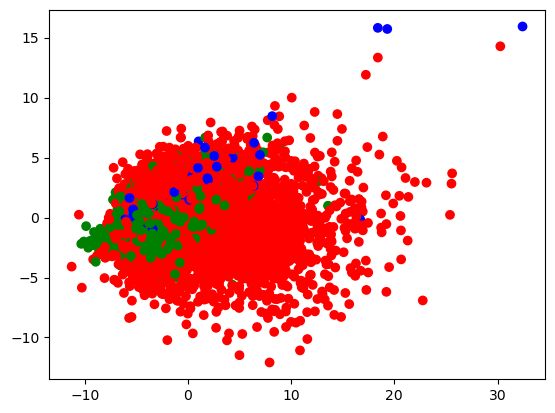

In [33]:
colors = {'cricket':'r', 'kaydid':'g', 'cicada':'b'}
plt.scatter(pipe.transform(X)[:,0], pipe.transform(X)[:,1], c = y.map(colors))
plt.show()

In [111]:
for n in range(5,20):
    A,B,C = plsr_test_acc(df, n_components=n)
    print(f'{n}: {r2_score(np.argmax(c.values,axis=1), np.argmax(B,axis=1))}')

5: -0.15247915922423405
6: -0.08891054232313
7: -0.05653027808913014
8: -0.03676441127144314
9: -0.05027274236292789
10: -0.03219541693167627
11: -0.02603720716938196
12: -0.02097158301007518
13: -0.023355406143866553
14: -0.0006097604089403408
15: 0.010713399476568908
16: 0.026804205629660793
17: 0.01637497941932342
18: 0.032962415391955324
19: 0.03455163081448287
